# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
WeAreOnColab = True

try:
  from google.colab import drive
  drive.mount('/content/drive')
except:
  WeAreOnColab = False

if WeAreOnColab is True:
  training_file = '/content/drive/My Drive/train.p'
  validation_file= '/content/drive/My Drive/valid.p'
  testing_file = '/content/drive/My Drive/test.p'
else:
  training_file = '../data/train.p'
  validation_file= '../data/valid.p'
  testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [3]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np

n_train = y_train.shape[0]
n_validation = y_valid.shape[0]
n_test = y_test.shape[0]
image_shape = X_train.shape[1:]
trainstat = np.unique(y_train, return_counts=False)
validstat = np.unique(y_valid, return_counts=False)
teststat  =  np.unique(y_test, return_counts=False)
allstat   = np.concatenate( (trainstat, validstat, teststat ) )
n_classes = len( np.unique( allstat, return_counts=False ) )

print("The size of training set is", n_train)
print("The size of the validation set is", n_validation)
print("The size of test set is", n_test)
print("The shape of a traffic sign image is", image_shape)
print("The number of unique classes/labels in the data set is", n_classes)

The size of training set is 34799
The size of the validation set is 4410
The size of test set is 12630
The shape of a traffic sign image is (32, 32, 3)
The number of unique classes/labels in the data set is 43


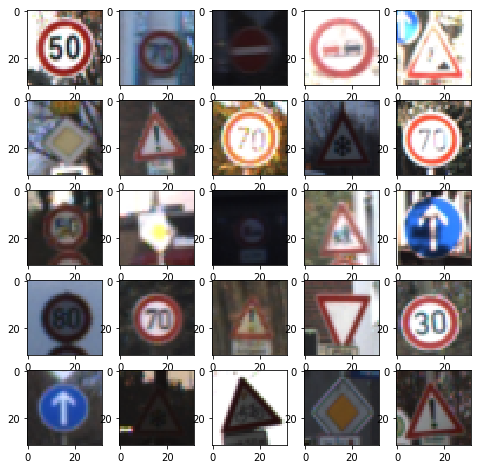

In [8]:
# Display a few images from the training set
import functools
import random
import numpy as np
import matplotlib.pyplot as plt
if WeAreOnColab is True:
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_eager_execution()
else:
  import tensorflow as tf 

columns = rows = 5
fig=plt.figure(figsize=(8, 8))

for i in range(1, columns*rows +1):
    index = random.randint(0, len(X_train))
    image_orig = X_train[index].squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_orig)




### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Label with most samples in the train set: 'Speed limit (50km/h)' Number of images: 2010'


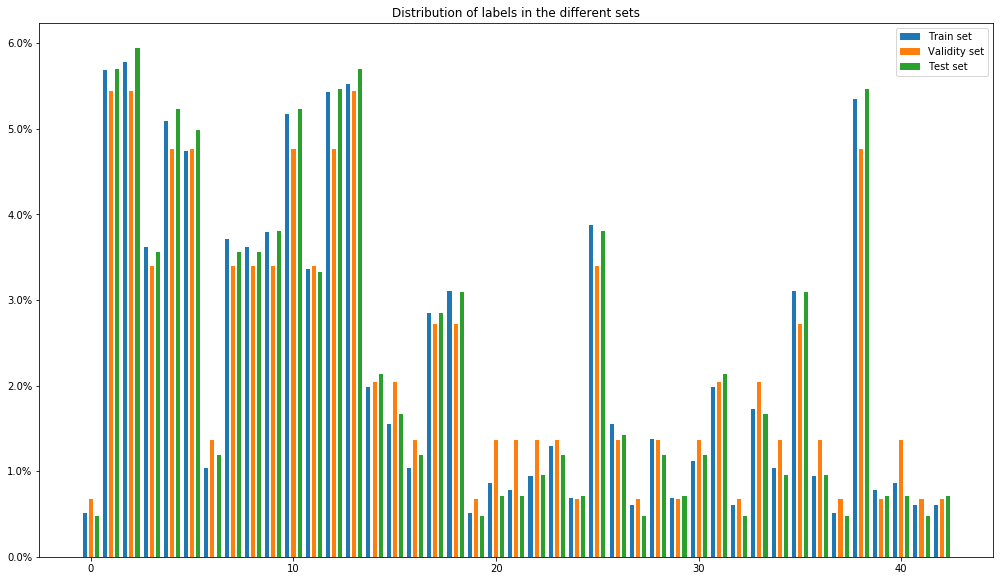

In [9]:
# show traffic sign distribution graph

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter
from skimage.transform import rescale, resize, downscale_local_mean
import csv

signnames = {} 

with open('signnames.csv', newline='') as csvfile:
  reader = csv.DictReader(csvfile)
  for row in reader:
    signnames[row['ClassId']] = row['SignName']
    
%matplotlib inline

def to_percent(y, position):
    # Ignore the passed in position. This has the effect of scaling the default
    # tick locations.
    s = str(100 * y)

    # The percent symbol needs escaping in latex
    if matplotlib.rcParams['text.usetex'] is True:
        return s + r'$\%$'
    else:
        return s + '%'

#########################################################
# Show the distibution of labels in the samples
#########################################################
lbls = y_train
maxlabel = np.max(y_train)# take the biggest set to ensure that all labels are in it
labels = np.arange(maxlabel+1)
trainstat = np.unique(y_train, return_counts=True)[1]
validstat = np.unique(y_valid, return_counts=True)[1]
teststat =  np.unique(y_test, return_counts=True)[1]

labelwithmostsamples = np.argmax(trainstat)
mostsamplescount = trainstat[labelwithmostsamples]

print ("Label with most samples in the train set: '{}' Number of images: {}'".format(signnames[str(labelwithmostsamples)], mostsamplescount))
fig, ax = plt.subplots(figsize=(14,8))
rects1 = ax.bar(labels-0.3, trainstat/len(y_train), 0.2, label='Train set')
rects2 = ax.bar(labels, validstat/len(y_valid), 0.2, label='Validity set')
rects3 = ax.bar(labels+0.3, teststat/len(y_test), 0.2, label='Test set')
ax.legend()
fig.tight_layout()

ax.set_title('Distribution of labels in the different sets')
formatter = FuncFormatter(to_percent)
plt.gca().yaxis.set_major_formatter(formatter)



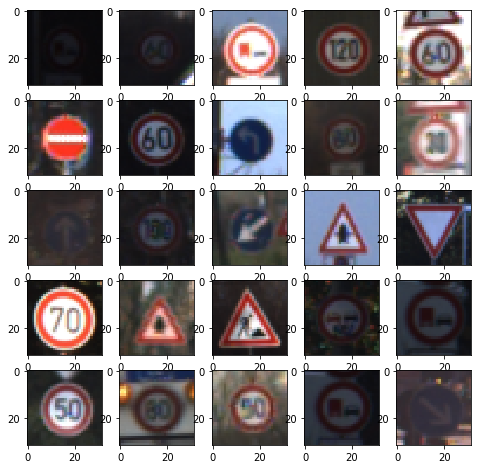

In [10]:
#########################################################
# Show a few random traffic signs from the train set
#########################################################

import random
import numpy as np
import matplotlib.pyplot as plt


columns = rows = 5
fig=plt.figure(figsize=(8, 8))

for i in range(1, columns*rows +1):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(image)



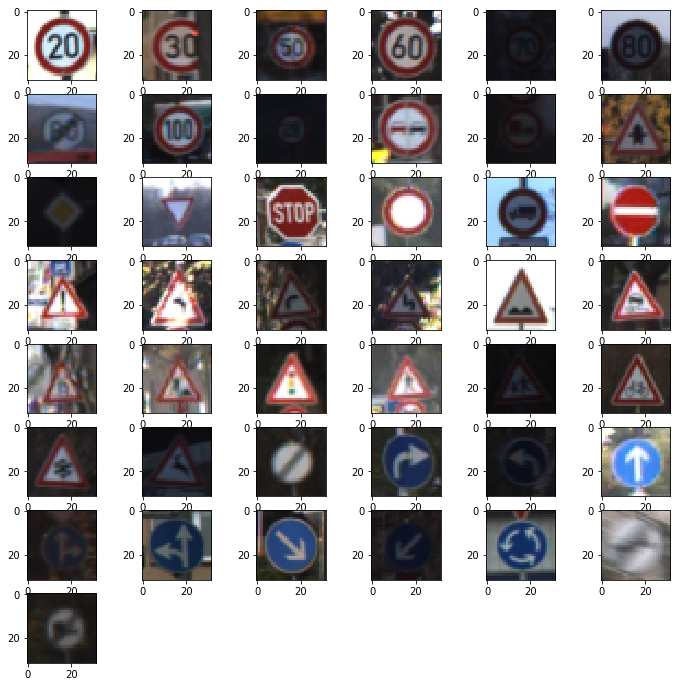

In [11]:
# show 1 random example image for each different traffic signs (total: 43) from the train set 
import random
import numpy as np
import matplotlib.pyplot as plt

columns = 6
rows = 8
fig=plt.figure(figsize=(12, 12))

for i in range(1, columns*rows +1):
    if i>43:
        continue
    xindices = np.where(y_train == (i-1))[0]    
    index = random.randint(0, len(xindices)-1)
    realidx = xindices[index]
    assert(y_train[realidx] == (i-1))
    image_orig = np.asarray( X_train[realidx], dtype=np.uint8 ).squeeze()
    fig.add_subplot(rows, columns, i)
    plt.imshow(image_orig)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

In [12]:
################################
### Expand training set
################################

from sklearn.utils import shuffle
from scipy import ndimage

def normalizeimage(img):
    if img.shape[2] == 4:
        img = rgba2rgb(img)
    if img.dtype == np.float64:
        # RGB values are [0,1]
        return (img - 0.5)/1.0
    else:
        # RGB values are [0,255]
        return (img - 128.0)/128.0
    
def random_distort_image(image):
    global k
    op = random.randint(1,3)
    if op == 1:
        rv = ndimage.rotate(image, np.random.uniform(-10.0,10.0), reshape=False)
        rv = np.clip(rv,0,255)
        rv = np.cast['uint8'](rv)
    if op == 2:    
        rv = image + 0.1 * image.std() * np.random.random(image.shape)
        rv = np.clip(rv,0,255)
        rv = np.cast['uint8'](rv)
    if op == 3:    
        rv = image - 0.1 * image.std() * np.random.random(image.shape)
        rv = np.clip(rv,0,255)
        rv = np.cast['uint8'](rv)
    if op == 4:    
        rv = image
                
    return rv

def extend_training_set(xset, yset, lbl, num):
    xindices = np.where(yset == lbl)[0]
    xadd = np.empty( [num, 32, 32, 3], dtype=np.int32 )
    idx = 0
    for i in range(0, num):
        index = random.randint(0, len(xindices)-1)
        assert( yset[xindices[index]] == lbl )
        xadd[idx] = random_distort_image(xset[xindices[index]])
        idx = idx + 1
    yadd = np.full( (num), lbl )
    ytoret=np.concatenate( (yset,yadd), axis=0 )  
    xtoret=np.concatenate( (xset,xadd), axis=0 )  
    return (xtoret, ytoret)
 
traincnts = np.unique(y_train, return_counts=True)[1]
(X_train_expanded, y_train_expanded) = (X_train, y_train)
for i in labels:
    extraimagescnt = mostsamplescount - traincnts[i]
    if extraimagescnt>0:
        (X_train_expanded, y_train_expanded) = extend_training_set(X_train_expanded, y_train_expanded, i, extraimagescnt)
print("Training set expanded to include {} images for each label. ".format(mostsamplescount))
assert( 43*mostsamplescount == len(X_train_expanded) )

# final normalization
X_train_normalized = normalizeimage(X_train_expanded)  
X_valid_normalized = normalizeimage(X_valid)           
X_test_normalized = normalizeimage(X_test)             
print ("Complete (expanded) training set size: {} images.".format(len(X_train_normalized)))
print ("Validation set size: {} images.".format(len(X_valid_normalized)))
print ("Test set size: {} images.".format(len(X_test_normalized)))


Training set expanded to include 2010 images of each labels. 
Complete (expanded) training set size: 86430 images.
Validation set size: 4410 images.
Test set size: 12630 images.


### Model Architecture

In [13]:
if WeAreOnColab is True:
  from tensorflow.compat.v1.layers import flatten
else:    
  from tensorflow.contrib.layers import flatten

#tf.compat.v1.disable_eager_execution()

def LeNet(x):    
    mu = 0
    sigma = 0.1
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.tanh(conv1)
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    conv2 = tf.nn.tanh(conv2)
    conv2 = tf.nn.avg_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    fc0   = flatten(conv2)    
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 350), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(350))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    fc1    = tf.nn.sigmoid(fc1)
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(350, 200), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(200))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b    
    fc2    = tf.nn.sigmoid(fc2)
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(200, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [14]:
#physical_devices = tf.config.experimental.list_physical_devices('GPU')
#assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
#config = tf.config.experimental.set_memory_growth(physical_devices[0], True)

#tf.compat.v1.disable_eager_execution()
# Train the network here
print( "Is_gpu_available :" + str(tf.test.is_gpu_available()) )
    
EPOCHS = 25
BATCH_SIZE = 128

# add variables
learning_rate = 0.001

x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, 43)
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

last_validation_accuracy = 0
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    print("Training...")
    print()
    prev_maxlabel = -1
    for i in range(EPOCHS):
        num_examples = len(X_train_normalized)

        X_train_normalized, y_train_expanded = shuffle(X_train_normalized, y_train_expanded)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_normalized[offset:end], y_train_expanded[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        validation_accuracy = evaluate(X_valid_normalized, y_valid)
        if (i % 10) == 9:
          learning_rate = learning_rate * 0.5
          print ("Learning_rate decreased to " + str(learning_rate) )
        last_validation_accuracy = validation_accuracy
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
    saver.save(sess, './lenet')     #, write_meta_graph=False)    
    print("Model saved")


Is_gpu_available :False
Training...



KeyboardInterrupt: 

In [ ]:
# Evaluate the network on expanded train set, validity set and test set. 
saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    train_accuracy = evaluate(X_train_normalized, y_train_expanded)
    valid_accuracy = evaluate(X_valid_normalized, y_valid)
    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Accuracy on the expanded train dataset = {:.3f}".format(train_accuracy))
    print("Accuracy on the validation dataset = {:.3f}".format(valid_accuracy))
    print("Accuracy on the (never seen) test dataset = {:.3f}".format(test_accuracy))
    print()
        

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

In [ ]:
# load and recale the custom images to 32x32 
from skimage.transform import rescale, resize, downscale_local_mean
import matplotlib.pyplot as plt

def rescale_image(img):
  return resize(img, (32,32), anti_aliasing=True)

custom_sign_names = ('sign1', 
                     'sign2', 
                     'sign3', 
                     'sign4', 
                     'sign5', 
                     'sign6', 
                     'sign7', 
                     )

for fname in custom_sign_names:
            plt.imsave( 'additionalsigns/rescaled_{}.jpg'.format(fname), rescale_image( plt.imread( 'additionalsigns/{}.jpg'.format(fname) )) )


In [ ]:
# Make a prediction on a random image from the valid set

import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgba2rgb

inputs = np.zeros( (1, 32,32,3), dtype=np.float64 )
idx = random.randint(0, len(X_valid))
inputs[0] = X_valid[idx]
lbl = y_valid[idx]
plt.imshow(X_valid[idx])
    
saver = tf.train.Saver()
am = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    o = sess.run(am, feed_dict={x: inputs})
    print ("Prediction: {}".format(signnames[str(o[0])]))
    

In [ ]:
# Test prediction: try to recognize 5 traffic signs from one of the input data sets 

import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgba2rgb

columns = 5
rows = 1
inputs = np.zeros( (columns, 32,32,3), dtype=np.float64 )

fig, axes = plt.subplots(rows,columns, figsize = (16,12))

for i in range(1, columns +1):
    index = random.randint(0, len(X_train))
    image = X_train[index].squeeze()
    inputs[i-1] = normalizeimage(image)
    axes[i-1].imshow(image)
   
saver = tf.train.Saver()
am = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    o = sess.run(am, feed_dict={x: inputs})
    for i in range(1, columns +1):
        axes[i-1].set_title(signnames[str(o[i-1])], fontsize=12)
    

### Load and predict the type of a few traffic sign images downloaded from web  

In [ ]:
# -------------------------------
# Load the custom images and recogized them using the neural network.
# Just for fun: 
#     the last two signs are unknown to the network, it never saw those traffic sign types. 
#     The NN recognized them as the most similar sign taught to it.
# -------------------------------

import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgba2rgb
        
columns = len(custom_sign_names)
rows = 1
inputs = np.zeros( (columns, 32,32,3), dtype=np.float64 )

fig, axes = plt.subplots(rows,columns, figsize = (16,12))

for i in range(1, columns +1):
    fname = custom_sign_names[i-1]
    img = plt.imread('additionalsigns/rescaled_{}.jpg'.format(fname))
    inputs[i-1] = normalizeimage(img)
    axes[i-1].imshow(img)
   
saver = tf.train.Saver()
am = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    o = sess.run(am, feed_dict={x: inputs})
    for i in range(1, columns +1):
        print("Predicted label for image#{}: {}".format( i, o[i-1] ))
        axes[i-1].set_title(signnames[str(o[i-1])], fontsize=8)
plt.show()
    

### Analyze Performance

In [ ]:
### Calculate the accuracy for the 5 new images (leave out the last 2 "unknown" images now). 

correctlabels = [ 1,38,11,27,14 ]
inputs = np.zeros( (len(correctlabels), 32,32,3), dtype=np.float64 )
for i in range(1, len(correctlabels)+1):
    fname = custom_sign_names[i-1]
    img = plt.imread('additionalsigns/rescaled_{}.jpg'.format(fname))
    inputs[i-1] = normalizeimage(img)
    

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    o = sess.run(correct_prediction, feed_dict={x: inputs, y: correctlabels})
    accuracy_percentage = np.count_nonzero(o) / len(o)
    print("Successfully recognized {:.2%} of the images.".format( accuracy_percentage ))
    



### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.


correctlabels = [ 1,38,11,27,14 ]
inputs = np.zeros( (len(correctlabels), 32,32,3), dtype=np.float64 )
for i in range(1, len(correctlabels)+1):
    fname = custom_sign_names[i-1]
    img = plt.imread('additionalsigns/rescaled_{}.jpg'.format(fname))
    inputs[i-1] = normalizeimage(img)
    
softmax_prob = tf.nn.softmax(logits)
topnum = 5

with tf.Session() as sess:
    saver.restore(sess, './lenet')
    o = sess.run(tf.nn.top_k(softmax_prob, k=topnum), feed_dict={x: inputs})
    for i in range(1,len(correctlabels)+1):
        print("Sign #{}:".format(i))
        for j in range(1, topnum+1):            
            print("Probability: {:.4%} Prediction: '{}' ".format( o[0][i-1][j-1], signnames[str(o[1][i-1][j-1])] ))
    
    

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.